In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

In [79]:
df_train = pd.read_csv('train.csv', skipinitialspace=True)

df_test = pd.read_csv('test.csv', skipinitialspace=True)

In [4]:
df_train 

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Long Road,241760,False,46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.2810,0.6350,142.221,241760,4.0,567.0,141.0,NaN,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",444000,False,0,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.3600,0.0336,75.596,444000,4.0,617.0,155.0,NaN,2.367412,iranian
2,Ondskapens Galakse,333506,False,3,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.2620,0.4890,116.628,333507,4.0,652.0,162.0,NaN,3.700483,black-metal
3,Can't Look Away,269800,False,23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.1170,0.3850,140.880,269800,4.0,619.0,155.0,0.469,1.279305,bluegrass
4,Thunderground,307651,False,25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.2990,0.6370,143.956,307652,4.0,733.0,183.0,NaN,4.067086,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Outpt,432026,False,0,Autechre,EP7,0.554,0.657,1,-14.232,...,0.1320,0.0335,117.319,432027,NaN,837.0,212.0,NaN,2.367412,idm
14996,Natural Environment Sounds: To Improve Sleep a...,182746,False,44,Natural White Noise Relaxation,Baby Sleep White Noise: Ultimate Album to Help...,0.103,0.860,1,-19.627,...,0.1230,0.0016,92.323,182747,3.0,277.0,92.0,NaN,2.367412,sleep
14997,Psychological Attack,400091,False,43,Droplex,Psychological Attack,0.799,0.535,1,-9.103,...,0.0713,0.0708,126.000,400091,4.0,837.0,209.0,NaN,2.367412,techno
14998,Don't Hate The 808 (feat. Lafa Taylor),197250,False,37,Bassnectar;Lafa Taylor,Noise vs Beauty,0.511,0.970,5,-2.299,...,0.4020,0.2700,160.044,197250,4.0,513.0,130.0,NaN,1.279305,breakbeat


## Data transformation

In [80]:
genres = df_train['genre'].unique()
# creo un dizionario per tenerli associati ad un numero
genres_dict = dict(zip(genres, range(len(genres))))
# Mappo i generi con i numeri
df_train['genre'] = df_train['genre'].map(genres_dict)
df_test['genre'] = df_test['genre'].map(genres_dict)
print(genres_dict)

{'j-dance': 0, 'iranian': 1, 'black-metal': 2, 'bluegrass': 3, 'happy': 4, 'industrial': 5, 'j-idol': 6, 'spanish': 7, 'sleep': 8, 'techno': 9, 'mandopop': 10, 'afrobeat': 11, 'disney': 12, 'study': 13, 'indian': 14, 'idm': 15, 'forro': 16, 'chicago-house': 17, 'brazil': 18, 'breakbeat': 19}


In [26]:
df_train['explicit'] = df_train['explicit'].astype(int)
df_test['explicit'] = df_test['explicit'].astype(int)

In [81]:
#Calculating only for the missing values in time_signature column by dividing n_beats/n_bars and rounding the result
df_train.loc[df_train['time_signature'].isna(), 'time_signature'] = round(df_train['n_beats'] / df_train['n_bars'])

df_test.loc[df_test['time_signature'].isna(), 'time_signature'] = round(df_test['n_beats'] / df_test['n_bars'])

StandarScaler normalization

In [45]:
from sklearn.preprocessing import StandardScaler

numerical_cols_train = df_train.select_dtypes(include=[np.number]).columns
numerical_cols_test = df_test.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()

scaler.fit(df_train[numerical_cols_train])

scaled_numerical_train = scaler.transform(df_train[numerical_cols_train])
scaled_numerical_test = scaler.transform(df_test[numerical_cols_test])

df_train[numerical_cols_train] = scaled_numerical_train
df_test[numerical_cols_test] = scaled_numerical_test

MinMax normalization

In [82]:
from sklearn.preprocessing import MinMaxScaler

numerical_cols_train = df_train.select_dtypes(include=[np.number]).columns
numerical_cols_test = df_test.select_dtypes(include=[np.number]).columns


scaler = MinMaxScaler()

scaler.fit(df_train[numerical_cols_train])

scaled_numerical_train = scaler.transform(df_train[numerical_cols_train])
scaled_numerical_test = scaler.transform(df_test[numerical_cols_test])

df_train[numerical_cols_train] = scaled_numerical_train
df_test[numerical_cols_test] = scaled_numerical_test

In [83]:
#Dropping popularity confidence column
df_train.drop(columns=['popularity_confidence'], axis=1, inplace=True)
df_test.drop(columns=['popularity_confidence'], axis=1, inplace=True)

In [84]:
# Load your dataset
df_copy = df_train.copy()
df_copy_test = df_test.copy()

# Drop unnecessary columns
columns_to_drop = ['name', 'artists', 'album_name', 'explicit']
df_copy.drop(columns=columns_to_drop, axis=1, inplace=True)
df_copy_test.drop(columns=columns_to_drop, axis=1, inplace=True)


# Divide the dataset: one with known mode and one with missing mode
data_with_mode = df_copy.dropna(subset=['mode'])
data_missing_mode = df_copy[df_copy['mode'].isna()]
data_missing_mode_test = df_copy_test[df_copy_test['mode'].isna()]

# Features and target variable for the known 'mode'
X_known = data_with_mode.drop(columns=['mode'])
y_known = data_with_mode['mode']

# Features for the rows with missing 'mode'
X_missing = data_missing_mode.drop(columns=['mode'])
X_missing_test = data_missing_mode_test.drop(columns=['mode'])

# Train a classifier (e.g., Random Forest) on data with known 'mode'
clf = RandomForestClassifier(n_estimators=500, random_state=42, max_features=20)
clf.fit(X_known, y_known)

# Separate known and unknown 'mode' in test set
test_known_mode = df_copy_test.dropna(subset=['mode'])
test_unknown_mode = df_copy_test[df_copy_test['mode'].isna()]

# Features and actual 'mode' values for known 'mode' part of test set
X_test_known = test_known_mode.drop(columns=['mode'])
y_test_actual = test_known_mode['mode']

# Predict 'mode' for the known part of the test set
y_test_pred = clf.predict(X_test_known)

# Calculate accuracy
accuracy = accuracy_score(y_test_actual, y_test_pred)
print("Accuracy on test set:", accuracy)

# Predict 'mode' for rows with missing 'mode' in training and test set
y_missing_pred = clf.predict(X_missing)
y_missing_pred_test = clf.predict(X_missing_test)

# Fill in the missing 'mode' values with predictions in training and test sets
df_train.loc[df_train['mode'].isna(), 'mode'] = y_missing_pred
df_test.loc[df_test['mode'].isna(), 'mode'] = y_missing_pred_test


Accuracy on test set: 0.7208250918338514


## Data classification

### Partitioning 

No classifying needed because the dataset is already divided in train and test

In [154]:
df_train

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Long Road,0.056710,False,0.489362,Funki Porcini,Hed Phone Sex,0.704082,0.513,0.454545,0.702298,...,0.536000,0.282696,0.638191,0.644920,0.056710,0.8,0.077164,0.064977,0.160046,0.000000
1,"Daniâl My Son, Where Did You Vanish?",0.105897,False,0.000000,Siavash Amini,A Trail of Laughters,0.070408,0.196,0.090909,0.469376,...,0.934000,0.362173,0.033769,0.342800,0.105897,0.8,0.083968,0.071429,0.487891,0.052632
2,Ondskapens Galakse,0.079024,False,0.031915,Kvelertak,Nattesferd,0.370408,0.854,0.181818,0.798793,...,0.800000,0.263581,0.491457,0.528865,0.079024,0.8,0.088732,0.074654,0.889543,0.105263
3,Can't Look Away,0.063530,False,0.244681,The Wood Brothers,One Drop of Truth,0.533673,0.585,0.454545,0.833678,...,0.001270,0.117706,0.386935,0.638839,0.063530,0.8,0.084241,0.071429,0.160046,0.157895
4,Thunderground,0.072736,False,0.265957,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.656122,0.687,0.636364,0.724866,...,0.096900,0.300805,0.640201,0.652788,0.072736,0.8,0.099755,0.084332,1.000000,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Outpt,0.102985,False,0.000000,Autechre,EP7,0.565306,0.657,0.090909,0.669976,...,0.615000,0.132797,0.033668,0.531999,0.102985,0.8,0.113909,0.097696,0.487891,0.789474
14996,Natural Environment Sounds: To Improve Sleep a...,0.042357,False,0.468085,Natural White Noise Relaxation,Baby Sleep White Noise: Ultimate Album to Help...,0.105102,0.860,0.090909,0.567578,...,0.940000,0.123742,0.001608,0.418651,0.042357,0.6,0.037697,0.042396,0.487891,0.421053
14997,Psychological Attack,0.095218,False,0.457447,Droplex,Psychological Attack,0.815306,0.535,0.090909,0.767324,...,0.857000,0.071730,0.071156,0.571364,0.095218,0.8,0.113909,0.096313,0.487891,0.473684
14998,Don't Hate The 808 (feat. Lafa Taylor),0.045885,False,0.393617,Bassnectar;Lafa Taylor,Noise vs Beauty,0.521429,0.970,0.454545,0.896464,...,0.000014,0.404427,0.271357,0.725741,0.045885,0.8,0.069815,0.059908,0.160046,1.000000


### KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier


In [163]:
from sklearn.neighbors import KNeighborsClassifier
#Create copies of the original datasets without 'name' , 'artists' and 'album_name' columns
knn_train = df_train.copy()
knn_test = df_test.copy()

knn_train.drop(columns=['name', 'artists', 'album_name', 'genre', 'key', 'popularity'], axis=1, inplace=True)
knn_test.drop(columns=['name', 'artists', 'album_name', 'genre', 'key', 'popularity'], axis=1, inplace=True)


In [164]:
# Using oversampling and SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE


X_train = knn_train.drop('explicit', axis=1)
y_train = knn_train['explicit']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smotee, y_train_smotee = smote.fit_resample(X_train, y_train)

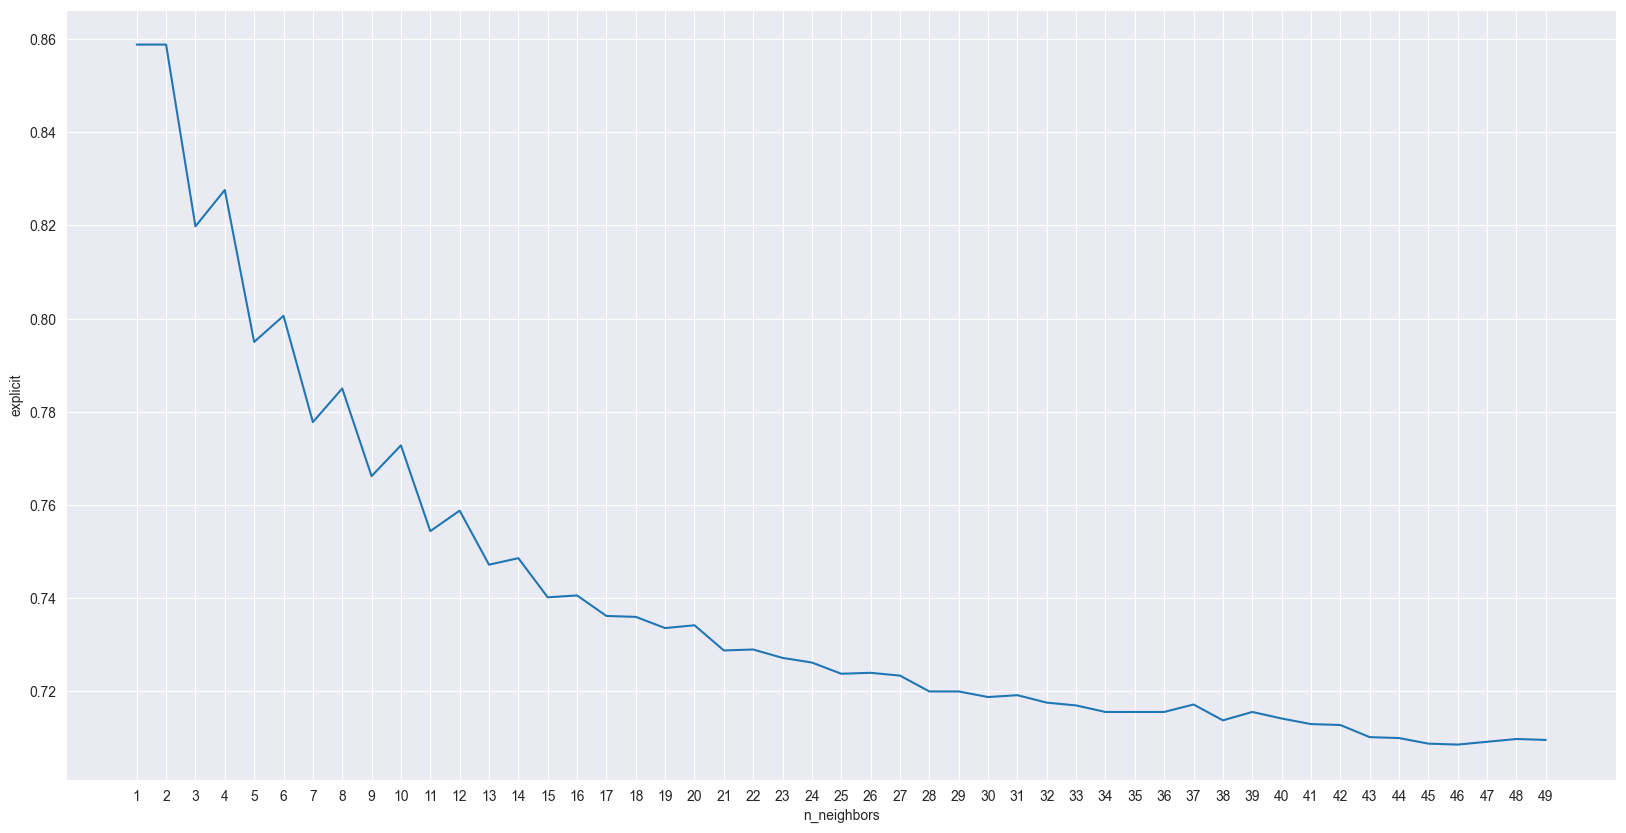

In [165]:
# Hyperparameter tuning

# Create a list of values for the hyperparameter
n_neighbors = list(range(1, 50))
scores = list()

# Create a classifier object with hyperparameter candidates
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train_smotee, y_train_smotee)
    scores.append(knn.score(knn_test.drop(columns=['explicit']), knn_test['explicit']))

# Plot the accuracy score for each value of n_neighbors, i want a large image
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('explicit')
plt.show()

In [118]:
#print the best score
print(max(scores))

0.9358


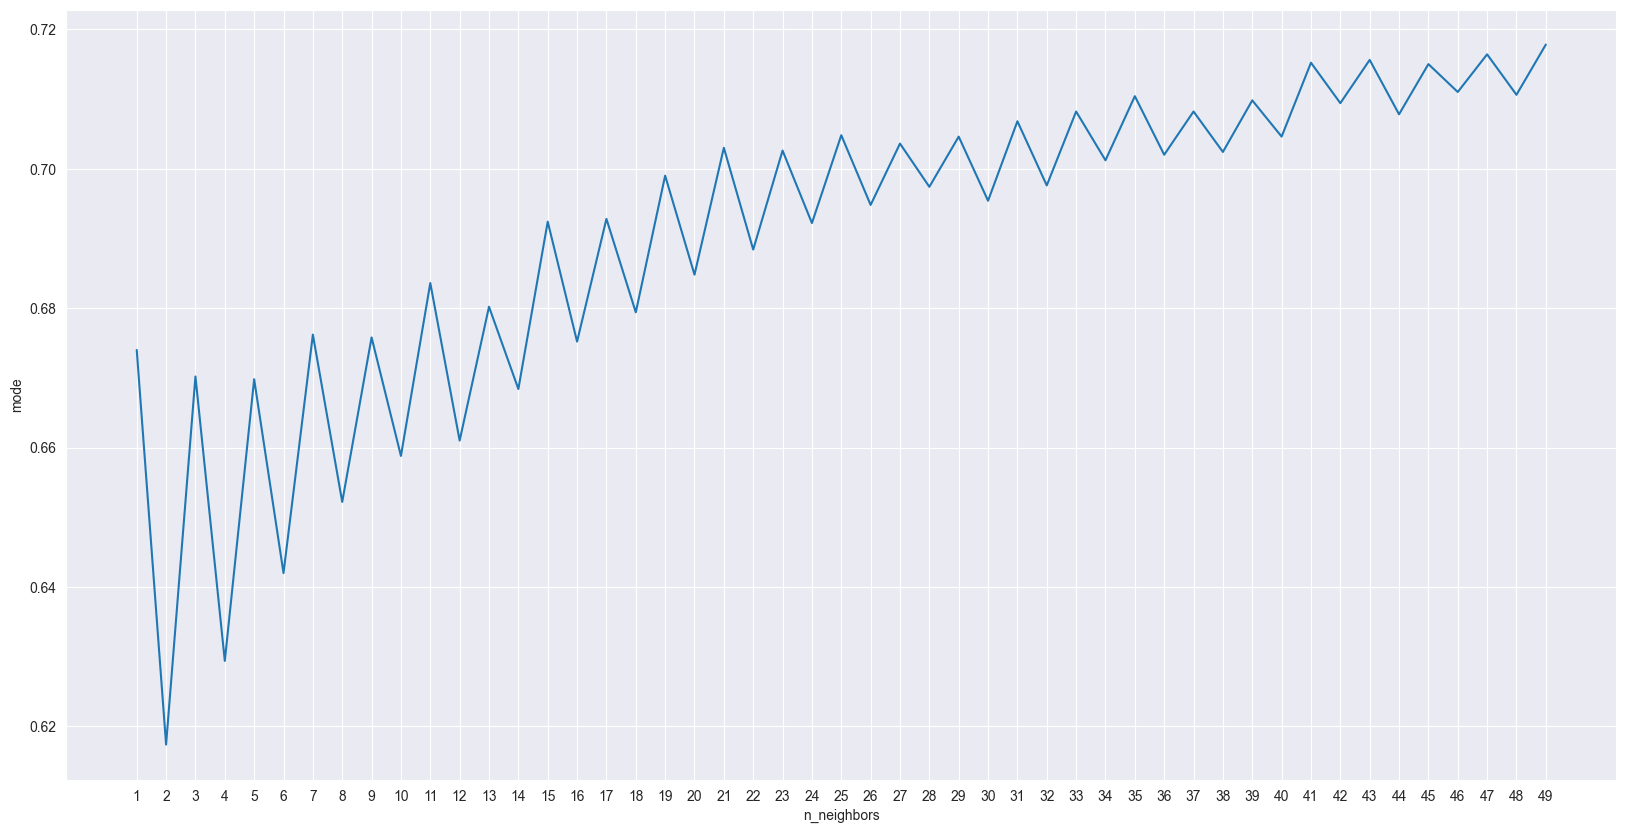

In [42]:
#Hyperparameter tuning

# Create a list of values for the hyperparameter
n_neighbors = list(range(1, 50))
scores = list()

# Create a classifier object with hyperparameter candidates
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i, weights='uniform')
    knn.fit(X_train_smote, y_train_smote)
    scores.append(knn.score(knn_test.drop(columns=['mode']), knn_test['mode']))

# Plot the accuracy score for each value of n_neighbors, i want a large image
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('mode')
plt.show()

#### Grid Search

In [121]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [125]:
param_grid = {
    "n_neighbors" : np.arange(1, 50),
    "weights" : ['uniform', 'distance'],
    "metric" : ['euclidean', 'manhattan', 'minkowski', 'cityblock']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=RepeatedStratifiedKFold(random_state=0), verbose=2, n_jobs=-1, refit=True)

grid.fit(knn_train.drop(columns=['explicit']), knn_train['explicit'])
clf = grid.best_estimator_

Fitting 50 folds for each of 392 candidates, totalling 19600 fits
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.8s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.8s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1, weights=uniform; total time=   0.7s
[CV] END ...metric=euclidean, n_neighbors=1

In [126]:
print(grid.best_params_, grid.best_score_)

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'distance'} 0.9368799999999999


In [131]:
#Predict genre for the test set
results = pd.DataFrame(grid.cv_results_)
results["metric_weight"] = results["param_metric"] + "," + results["param_weights"]

<AxesSubplot: xlabel='param_n_neighbors', ylabel='mean_test_score'>

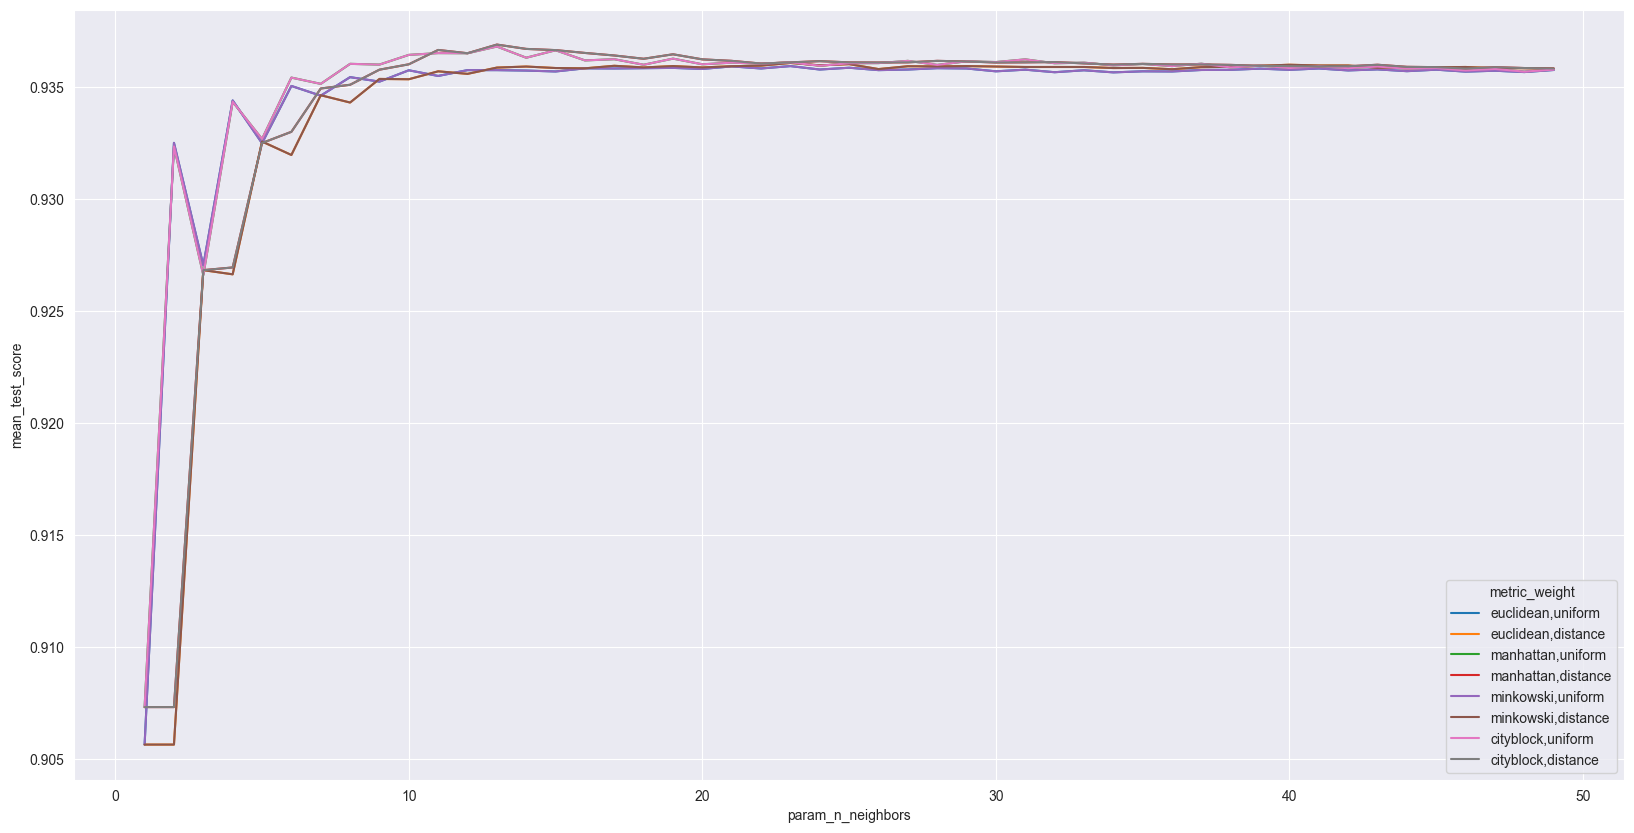

In [133]:
#Plot the results, big image
plt.figure(figsize=(20, 10))
sns.lineplot(data=results, x="param_n_neighbors", y="mean_test_score", hue="metric_weight")

In [136]:
knn_train 

,duration_ms,explicit,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,0.056710,False,0.489362,0.704082,0.513,0.454545,0.702298,1.0,0.103834,0.303213,0.536000,0.282696,0.638191,0.644920,0.056710,0.8,0.077164,0.064977,0.160046,0.000000
1,0.105897,False,0.000000,0.070408,0.196,0.090909,0.469376,0.0,0.085729,0.284137,0.934000,0.362173,0.033769,0.342800,0.105897,0.8,0.083968,0.071429,0.487891,0.052632
2,0.079024,False,0.031915,0.370408,0.854,0.181818,0.798793,1.0,0.042279,0.000090,0.800000,0.263581,0.491457,0.528865,0.079024,0.8,0.088732,0.074654,0.889543,0.105263
3,0.063530,False,0.244681,0.533673,0.585,0.454545,0.833678,1.0,0.081470,0.066667,0.001270,0.117706,0.386935,0.638839,0.063530,0.8,0.084241,0.071429,0.160046,0.157895
4,0.072736,False,0.265957,0.656122,0.687,0.636364,0.724866,1.0,0.057401,0.000578,0.096900,0.300805,0.640201,0.652788,0.072736,0.8,0.099755,0.084332,1.000000,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.102985,False,0.000000,0.565306,0.657,0.090909,0.669976,1.0,0.059425,0.016064,0.615000,0.132797,0.033668,0.531999,0.102985,0.8,0.113909,0.097696,0.487891,0.789474
14996,0.042357,False,0.468085,0.105102,0.860,0.090909,0.567578,1.0,0.063365,0.550201,0.940000,0.123742,0.001608,0.418651,0.042357,0.6,0.037697,0.042396,0.487891,0.421053
14997,0.095218,False,0.457447,0.815306,0.535,0.090909,0.767324,1.0,0.063259,0.001837,0.857000,0.071730,0.071156,0.571364,0.095218,0.8,0.113909,0.096313,0.487891,0.473684
14998,0.045885,False,0.393617,0.521429,0.970,0.454545,0.896464,1.0,0.056550,0.000338,0.000014,0.404427,0.271357,0.725741,0.045885,0.8,0.069815,0.059908,0.160046,1.000000


In [155]:
# Using oversampling and SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE


X_train = knn_train.drop('explicit', axis=1)
y_train = knn_train['explicit']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [156]:
# Using oversampling and SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE


X_train = knn_train.drop('mode', axis=1)
y_train = knn_train['mode']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [35]:
df_test

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Untrue,0.048214,0.0,0.340426,Coal Chamber,Chamber Music,0.390816,0.9510,0.000000,0.869057,...,0.000000,0.262575,0.671357,0.501458,0.048214,0.8,0.052395,0.044240,0.783659,0.263158
1,High Roller,0.078106,0.0,0.436170,The Crystal Method,Vegas,0.473469,0.5790,0.454545,0.766698,...,0.827000,0.099799,0.140704,0.778832,0.078106,0.8,0.127246,0.108295,0.160046,1.000000
2,Na Tum Jano Na Hum (ReVibe),0.030988,0.0,0.425532,Ashwin Adwani,Na Tum Jano Na Hum (ReVibe),0.623469,0.7780,0.818182,0.848938,...,0.000005,0.139839,0.286432,0.408226,0.030988,0.8,0.027218,0.022581,0.179406,0.736842
3,いじわるなハロー,0.057994,0.0,0.265957,Perfume,Cling Cling,0.510204,0.9580,0.000000,0.907928,...,0.318000,0.736419,0.959799,0.589770,0.057994,0.8,0.071584,0.060829,0.783659,0.315789
4,Hit The Ceiling,0.048529,0.0,0.000000,Audio Bullys,Ego War,0.818367,0.6840,0.090909,0.772335,...,0.010200,0.237425,0.640201,0.589602,0.048528,0.8,0.059880,0.050691,0.487891,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Ich war es,0.017566,0.0,0.180851,Germaine Franco,Encanto (Deutscher Original Film-Soundtrack),0.221429,0.0754,1.000000,0.624480,...,0.914000,0.135815,0.202010,0.644036,0.017566,1.0,0.023816,0.020276,0.000000,0.631579
4996,Giahe Vahshi,0.061511,0.0,0.021277,Saeed Dehghan;Pari Eskandari;Beatbynajwa,Oryan,0.476531,0.7820,0.909091,0.785678,...,0.000057,0.097686,0.204020,0.657789,0.061511,0.8,0.084513,0.072811,0.002794,0.052632
4997,Taste - Reaper Remix,0.060660,0.0,0.202128,Shiv-R,"Infacted Compilation, Vol. 5",0.534694,0.9730,0.000000,0.841137,...,0.005170,0.107646,0.844221,0.634980,0.060660,0.8,0.080838,0.068664,0.783659,0.263158
4998,Romove,0.096292,0.0,0.202128,Skyforger,Senprusija,0.169388,0.9750,0.181818,0.872056,...,0.005520,0.065996,0.234171,0.340120,0.096292,0.8,0.074850,0.063594,0.889543,0.105263


In [38]:
X_train_smote

,duration_ms,explicit,popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,0.056710,0.0,0.489362,0.704082,0.513000,0.454545,0.702298,0.103834,0.303213,0.536000,0.282696,0.638191,0.644920,0.056710,0.800000,0.077164,0.064977,0.160046,0.000000
1,0.105897,0.0,0.000000,0.070408,0.196000,0.090909,0.469376,0.085729,0.284137,0.934000,0.362173,0.033769,0.342800,0.105897,0.800000,0.083968,0.071429,0.487891,0.052632
2,0.079024,0.0,0.031915,0.370408,0.854000,0.181818,0.798793,0.042279,0.000090,0.800000,0.263581,0.491457,0.528865,0.079024,0.800000,0.088732,0.074654,0.889543,0.105263
3,0.063530,0.0,0.244681,0.533673,0.585000,0.454545,0.833678,0.081470,0.066667,0.001270,0.117706,0.386935,0.638839,0.063530,0.800000,0.084241,0.071429,0.160046,0.157895
4,0.072736,0.0,0.265957,0.656122,0.687000,0.636364,0.724866,0.057401,0.000578,0.096900,0.300805,0.640201,0.652788,0.072736,0.800000,0.099755,0.084332,1.000000,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19951,0.069981,0.0,0.160757,0.560431,0.853630,0.946128,0.828317,0.039778,0.004561,0.000641,0.161338,0.310702,0.586868,0.069981,0.800000,0.086126,0.072931,0.001656,0.241716
19952,0.051448,0.0,0.268063,0.652343,0.507332,0.727273,0.769725,0.044209,0.416503,0.020076,0.127295,0.728506,0.441779,0.051448,0.800000,0.048118,0.040827,0.595904,0.536271
19953,0.054230,1.0,0.268761,0.381065,0.946635,0.511159,0.861568,0.079101,0.000013,0.006163,0.310781,0.311835,0.632858,0.054199,0.800000,0.072486,0.061908,0.139716,0.164829
19954,0.061161,0.0,0.545796,0.609528,0.534711,0.424007,0.806220,0.034474,0.048054,0.061029,0.133567,0.249160,0.427311,0.061161,0.800000,0.056025,0.047235,0.123276,0.192437


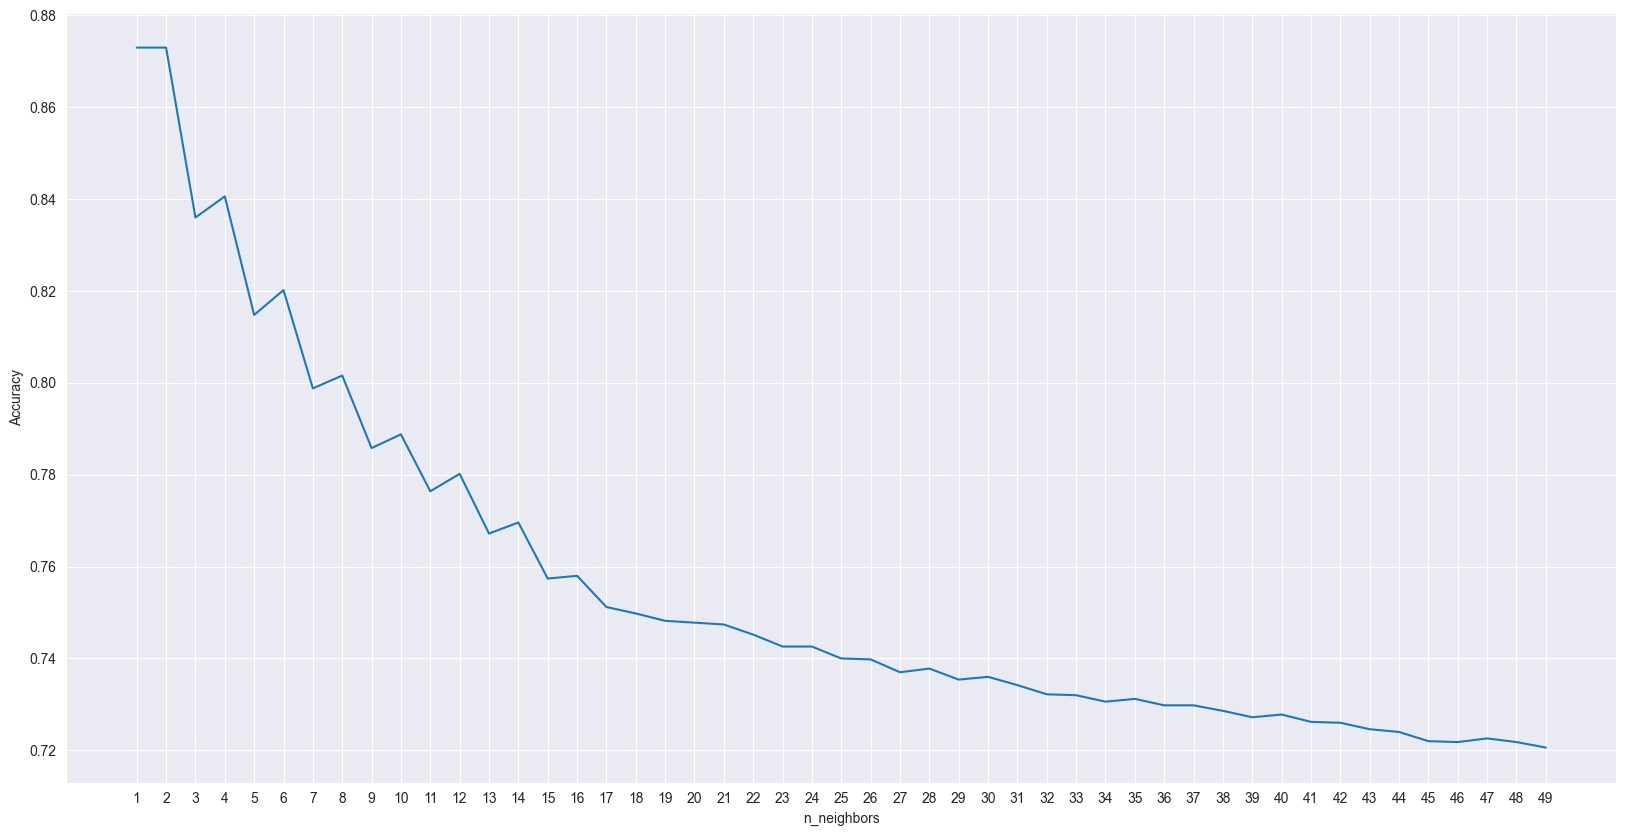

In [164]:
# Hyperparameter tuning

# Create a list of values for the hyperparameter
n_neighbors = list(range(1, 50))
scores = list()

# Create a classifier object with hyperparameter candidates
for i in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='manhattan')
    knn.fit(X_train_smote, y_train_smote)
    scores.append(knn.score(knn_test.drop(columns=['explicit']), knn_test['explicit']))

# Plot the accuracy score for each value of n_neighbors, i want a large image
plt.figure(figsize=(20, 10))
plt.plot(scores)
plt.xticks(range(len(n_neighbors)), n_neighbors)
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

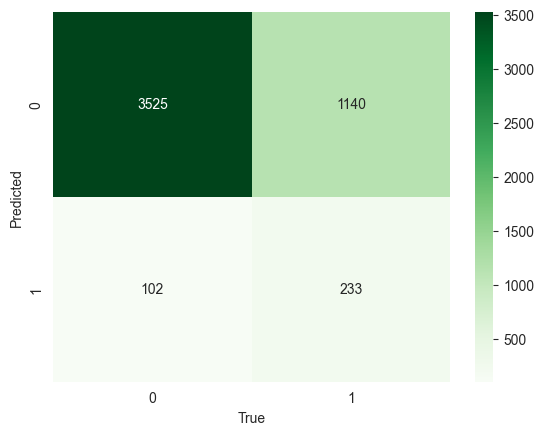

In [174]:
#confusion matrix
from sklearn.metrics import confusion_matrix
knn = KNeighborsClassifier(n_neighbors=15, weights='distance', metric='manhattan')
knn.fit(X_train_smotee, y_train_smotee)
y_pred = knn.predict(knn_test.drop(columns=['explicit']))
cf = confusion_matrix(knn_test['explicit'], y_pred)
sns.heatmap(cf, annot=True, cmap='Greens', fmt='d')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()


In [48]:
df_train

,name,duration_ms,explicit,popularity,artists,album_name,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,processing,genre
0,Long Road,0.056710,0.0,0.489362,Funki Porcini,Hed Phone Sex,0.704082,0.513,0.454545,0.702298,...,0.536000,0.282696,0.638191,0.644920,0.056710,0.8,0.077164,0.064977,0.160046,0.000000
1,"Daniâl My Son, Where Did You Vanish?",0.105897,0.0,0.000000,Siavash Amini,A Trail of Laughters,0.070408,0.196,0.090909,0.469376,...,0.934000,0.362173,0.033769,0.342800,0.105897,0.8,0.083968,0.071429,0.487891,0.052632
2,Ondskapens Galakse,0.079024,0.0,0.031915,Kvelertak,Nattesferd,0.370408,0.854,0.181818,0.798793,...,0.800000,0.263581,0.491457,0.528865,0.079024,0.8,0.088732,0.074654,0.889543,0.105263
3,Can't Look Away,0.063530,0.0,0.244681,The Wood Brothers,One Drop of Truth,0.533673,0.585,0.454545,0.833678,...,0.001270,0.117706,0.386935,0.638839,0.063530,0.8,0.084241,0.071429,0.160046,0.157895
4,Thunderground,0.072736,0.0,0.265957,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.656122,0.687,0.636364,0.724866,...,0.096900,0.300805,0.640201,0.652788,0.072736,0.8,0.099755,0.084332,1.000000,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,Outpt,0.102985,0.0,0.000000,Autechre,EP7,0.565306,0.657,0.090909,0.669976,...,0.615000,0.132797,0.033668,0.531999,0.102985,0.8,0.113909,0.097696,0.487891,0.789474
14996,Natural Environment Sounds: To Improve Sleep a...,0.042357,0.0,0.468085,Natural White Noise Relaxation,Baby Sleep White Noise: Ultimate Album to Help...,0.105102,0.860,0.090909,0.567578,...,0.940000,0.123742,0.001608,0.418651,0.042357,0.6,0.037697,0.042396,0.487891,0.421053
14997,Psychological Attack,0.095218,0.0,0.457447,Droplex,Psychological Attack,0.815306,0.535,0.090909,0.767324,...,0.857000,0.071730,0.071156,0.571364,0.095218,0.8,0.113909,0.096313,0.487891,0.473684
14998,Don't Hate The 808 (feat. Lafa Taylor),0.045885,0.0,0.393617,Bassnectar;Lafa Taylor,Noise vs Beauty,0.521429,0.970,0.454545,0.896464,...,0.000014,0.404427,0.271357,0.725741,0.045885,0.8,0.069815,0.059908,0.160046,1.000000


In [173]:
print(classification_report(knn_test['explicit'], y_pred)) #K=1

              precision    recall  f1-score   support

       False       0.97      0.79      0.87      4665
        True       0.18      0.64      0.29       335

    accuracy                           0.78      5000
   macro avg       0.58      0.72      0.58      5000
weighted avg       0.92      0.78      0.83      5000


In [171]:
print(classification_report(knn_test['explicit'], y_pred)) #k=10

              precision    recall  f1-score   support

       False       0.97      0.80      0.88      4665
        True       0.19      0.67      0.30       335

    accuracy                           0.79      5000
   macro avg       0.58      0.73      0.59      5000
weighted avg       0.92      0.79      0.84      5000


In [173]:
print(classification_report(knn_test['explicit'], y_pred)) #K=15

              precision    recall  f1-score   support

       False       0.97      0.76      0.85      4665
        True       0.18      0.71      0.28       335

    accuracy                           0.76      5000
   macro avg       0.57      0.74      0.57      5000
weighted avg       0.92      0.76      0.82      5000


True positive rate: 0.7419939577039275
False positive rate: 0.29289940828402367
True negative rate: 0.7071005917159763
False negative rate: 0.2580060422960725


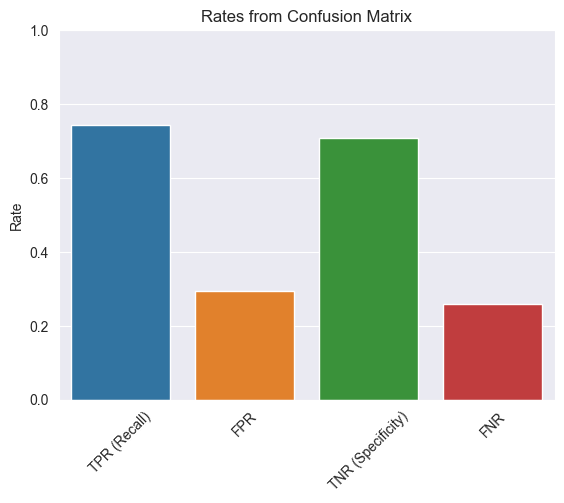

In [50]:
# Plot true positive rate, false positive rate, precision and recall
# Assuming 'cf' is the confusion matrix you have computed
TP = cf[1, 1]
TN = cf[0, 0]
FP = cf[0, 1]
FN = cf[1, 0]

# Calculate rates
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
TNR = TN / (TN + FP)
FNR = FN / (TP + FN)

print('True positive rate:', TPR)
print('False positive rate:', FPR)
print('True negative rate:', TNR)
print('False negative rate:', FNR)

# Create a bar plot for the rates
rates = {'TPR (Recall)': TPR, 'FPR': FPR, 'TNR (Specificity)': TNR, 'FNR': FNR}
names = list(rates.keys())
values = list(rates.values())

sns.barplot(x=names, y=values)
plt.title('Rates from Confusion Matrix')
plt.ylabel('Rate')
plt.ylim(0, 1)  # Limit y-axis to [0, 1] for rate representation
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [161]:
y_pred

array([False, False, False, ..., False,  True, False])

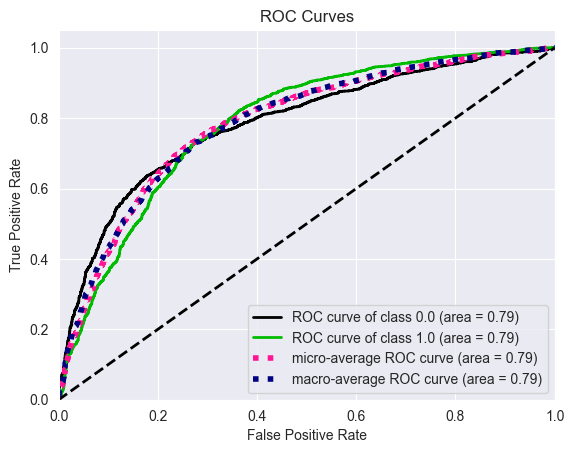

In [51]:
#roc curve
y_pred_proba = knn.predict_proba(knn_test.drop(columns=['mode']))
plot_roc(knn_test['mode'], y_pred_proba)
plt.show()

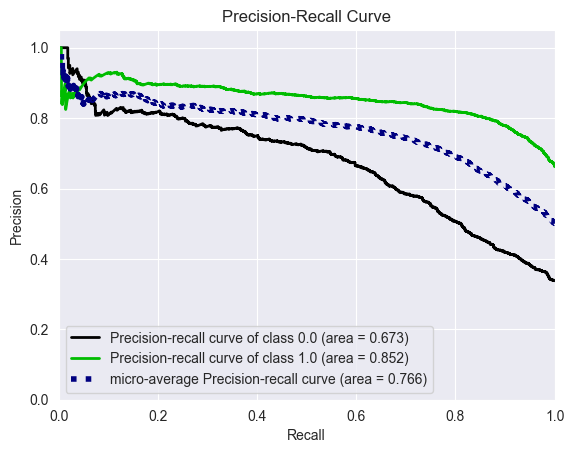

In [52]:
#plot the precision-recall curve
plot_precision_recall(knn_test['mode'], y_pred_proba)
plt.show()

## Naive Bayes

In [85]:
from sklearn.naive_bayes import GaussianNB

In [86]:
#Create copies of the original datasets without 'name' , 'artists' and 'album_name' columns
NB_train = df_train.copy()
NB_test = df_test.copy()

NB_train.drop(columns=['name', 'artists', 'album_name'], axis=1, inplace=True)
NB_test.drop(columns=['name', 'artists', 'album_name'], axis=1, inplace=True)

In [87]:
# Using oversampling and SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE


X_train = NB_train.drop('explicit', axis=1)
y_train = NB_train['explicit']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [66]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)

nbModel_grid.fit(X_train_smote, y_train_smote)

print(nbModel_grid.best_estimator_)
print(nbModel_grid.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.01)
0.7259506513220055


In [147]:
clf = GaussianNB(var_smoothing=0.0005)
clf.fit(X_train_smote, y_train_smote)
#accuracy 
clf.score(NB_test.drop(columns=['explicit']), NB_test['explicit'])

y_pred = clf.predict(NB_test.drop(columns=['explicit']))

print(classification_report(NB_test['explicit'], y_pred))


              precision    recall  f1-score   support

       False       0.98      0.56      0.71      4665
        True       0.12      0.81      0.20       335

    accuracy                           0.57      5000
   macro avg       0.55      0.68      0.46      5000
weighted avg       0.92      0.57      0.67      5000


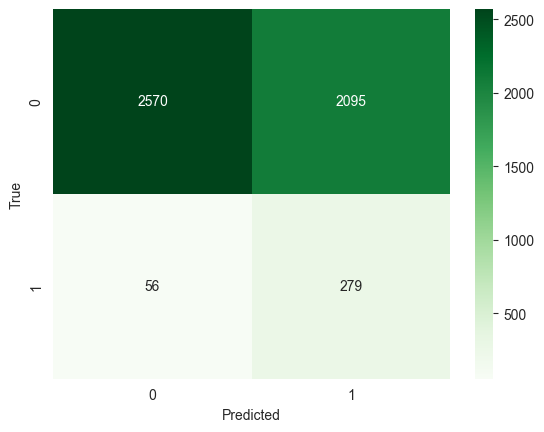

In [74]:
#confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(NB_test['explicit'], y_pred)
sns.heatmap(cf, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

True positive rate: 0.8328358208955224
False positive rate: 0.4490889603429796
True negative rate: 0.5509110396570204
False negative rate: 0.16716417910447762


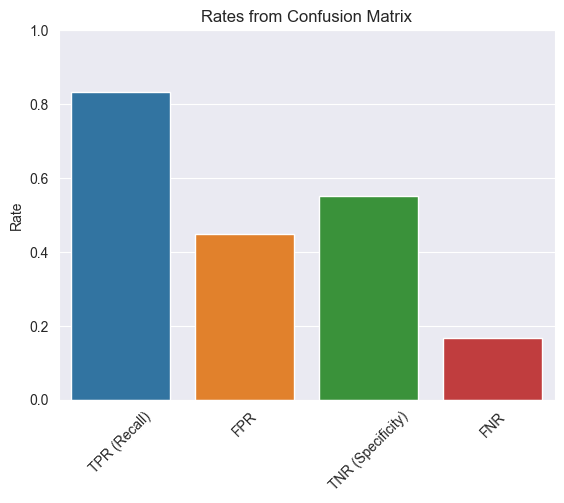

In [69]:
# Plot true positive rate, false positive rate, precision and recall
# Assuming 'cf' is the confusion matrix you have computed
TP = cf[1, 1]
TN = cf[0, 0]
FP = cf[0, 1]
FN = cf[1, 0]

# Calculate rates
TPR = TP / (TP + FN)
FPR = FP / (TN + FP)
TNR = TN / (TN + FP)
FNR = FN / (TP + FN)

print('True positive rate:', TPR)
print('False positive rate:', FPR)
print('True negative rate:', TNR)
print('False negative rate:', FNR)

# Create a bar plot for the rates
rates = {'TPR (Recall)': TPR, 'FPR': FPR, 'TNR (Specificity)': TNR, 'FNR': FNR}
names = list(rates.keys())
values = list(rates.values())

sns.barplot(x=names, y=values)
plt.title('Rates from Confusion Matrix')
plt.ylabel('Rate')
plt.ylim(0, 1)  # Limit y-axis to [0, 1] for rate representation
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


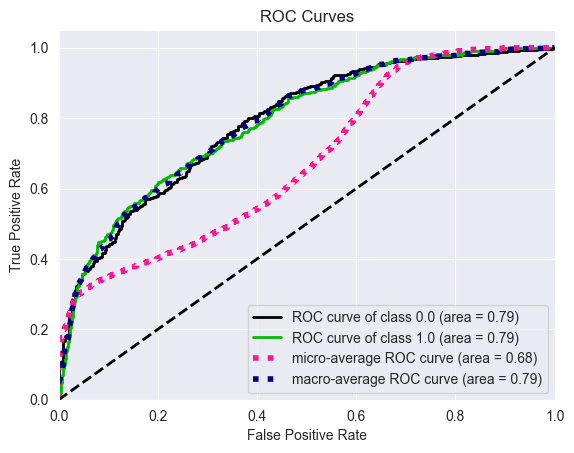

In [76]:
#roc curve
y_pred_proba = clf.predict_proba(NB_test.drop(columns=['explicit']))
plot_roc(NB_test['explicit'], y_pred_proba)
plt.show()


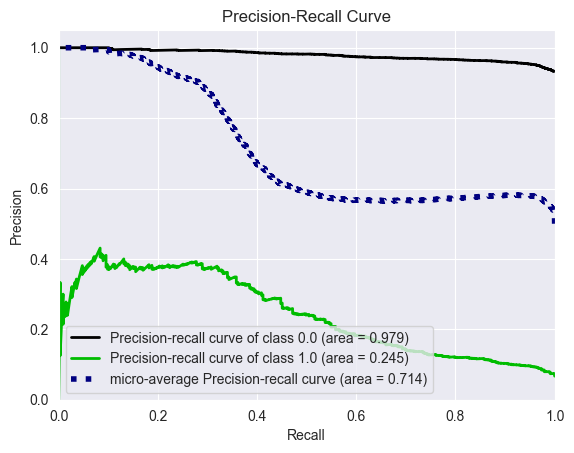

In [75]:
#plot the precision-recall curve
plot_precision_recall(NB_test['explicit'], y_pred_proba)
plt.show()


## Decision Tree

In [91]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [92]:
dt = DecisionTreeClassifier(random_state=42)

In [93]:
#Create copies of the original datasets without 'name' , 'artists' and 'album_name' columns
dt_train = df_train.copy()
dt_test = df_test.copy()

dt_train.drop(columns=['name', 'artists', 'album_name'], axis=1, inplace=True)
dt_test.drop(columns=['name', 'artists', 'album_name'], axis=1, inplace=True)

In [104]:
# Using oversampling and SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE


X_train = dt_train.drop('explicit', axis=1)
y_train = dt_train['explicit']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#Now i want to divide the train dataset in train and validation
X_train_smotee, X_val_smote, y_train_smotee, y_val_smote = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)

In [105]:
dt.fit(X_train_smotee, y_train_smotee)

DecisionTreeClassifier(random_state=42)

In [106]:
#Predict on the validation
y_pred = dt.predict(X_val_smote)
y_test_pred = dt.predict(dt_test.drop(columns=['explicit']))

In [107]:
print('Train accuracy %s' % accuracy_score(y_val_smote, y_pred))
print('Test accuracy %s' % accuracy_score(dt_test['explicit'], y_test_pred))


Train accuracy 0.903277520484503
Test accuracy 0.8592


In [108]:
print(classification_report(dt_test['explicit'], y_test_pred))

              precision    recall  f1-score   support

       False       0.96      0.89      0.92      4665
        True       0.23      0.47      0.31       335

    accuracy                           0.86      5000
   macro avg       0.59      0.68      0.61      5000
weighted avg       0.91      0.86      0.88      5000


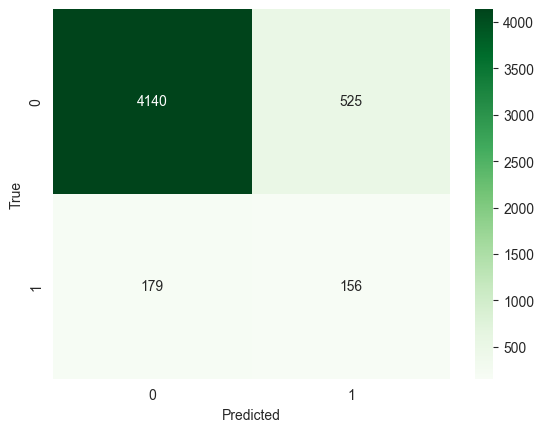

In [109]:
cf = confusion_matrix(dt_test['explicit'], y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [110]:
zipped = zip(dt_train.drop(columns=['explicit']), dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, score in zipped:
    print(col, score)

speechiness 0.3147025724559141
genre 0.13775081464530275
instrumentalness 0.07608461798448451
danceability 0.06080576815341217
acousticness 0.05521283719606611
loudness 0.04702264914420385
valence 0.04384615261614072
popularity 0.038445995214821706
liveness 0.035141856667495
tempo 0.035063234916941875
energy 0.03005874440258388
key 0.027293900356268885
processing 0.02196367273061649
n_bars 0.0173496973312245
n_beats 0.01652100300415081
duration_ms 0.01614768129177301
features_duration_ms 0.012381255688078102
time_signature 0.009529488616170973
mode 0.004678057584350566


In [111]:
from sklearn.model_selection import cross_val_score

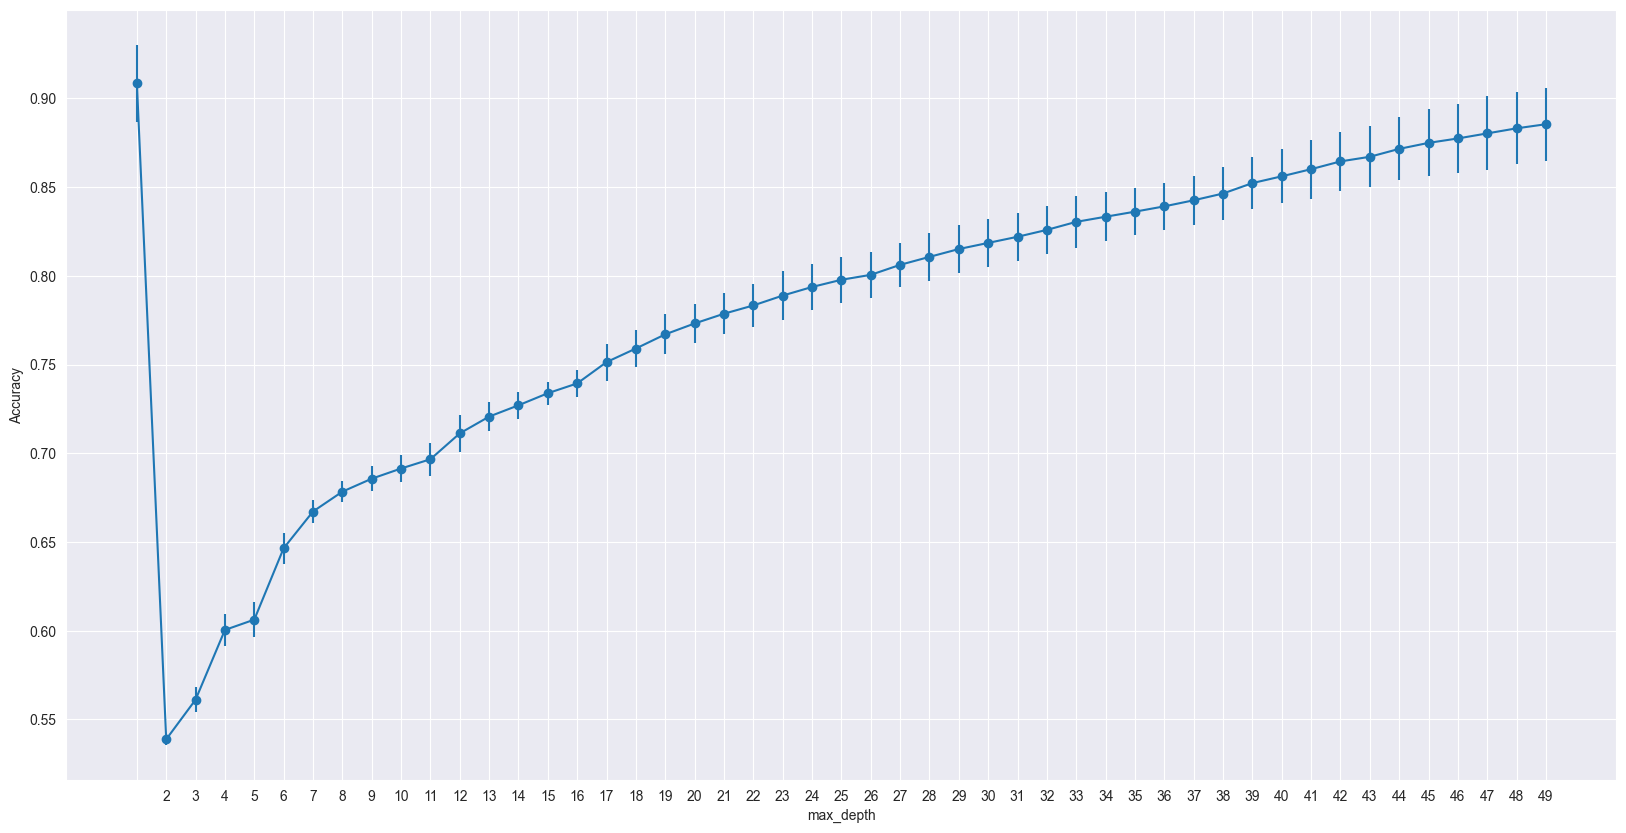

In [140]:
max_depths = [None] + list(np.arange(2,50))
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, random_state=42, class_weight={0: 0.1, 1: 10})
    scores = cross_val_score(dt, X_train_smote, y_train_smote, cv=10)
    avg_scores.append(scores.mean())
    std_scores.append(scores.std())

plt.figure(figsize=(20, 10))
plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show()

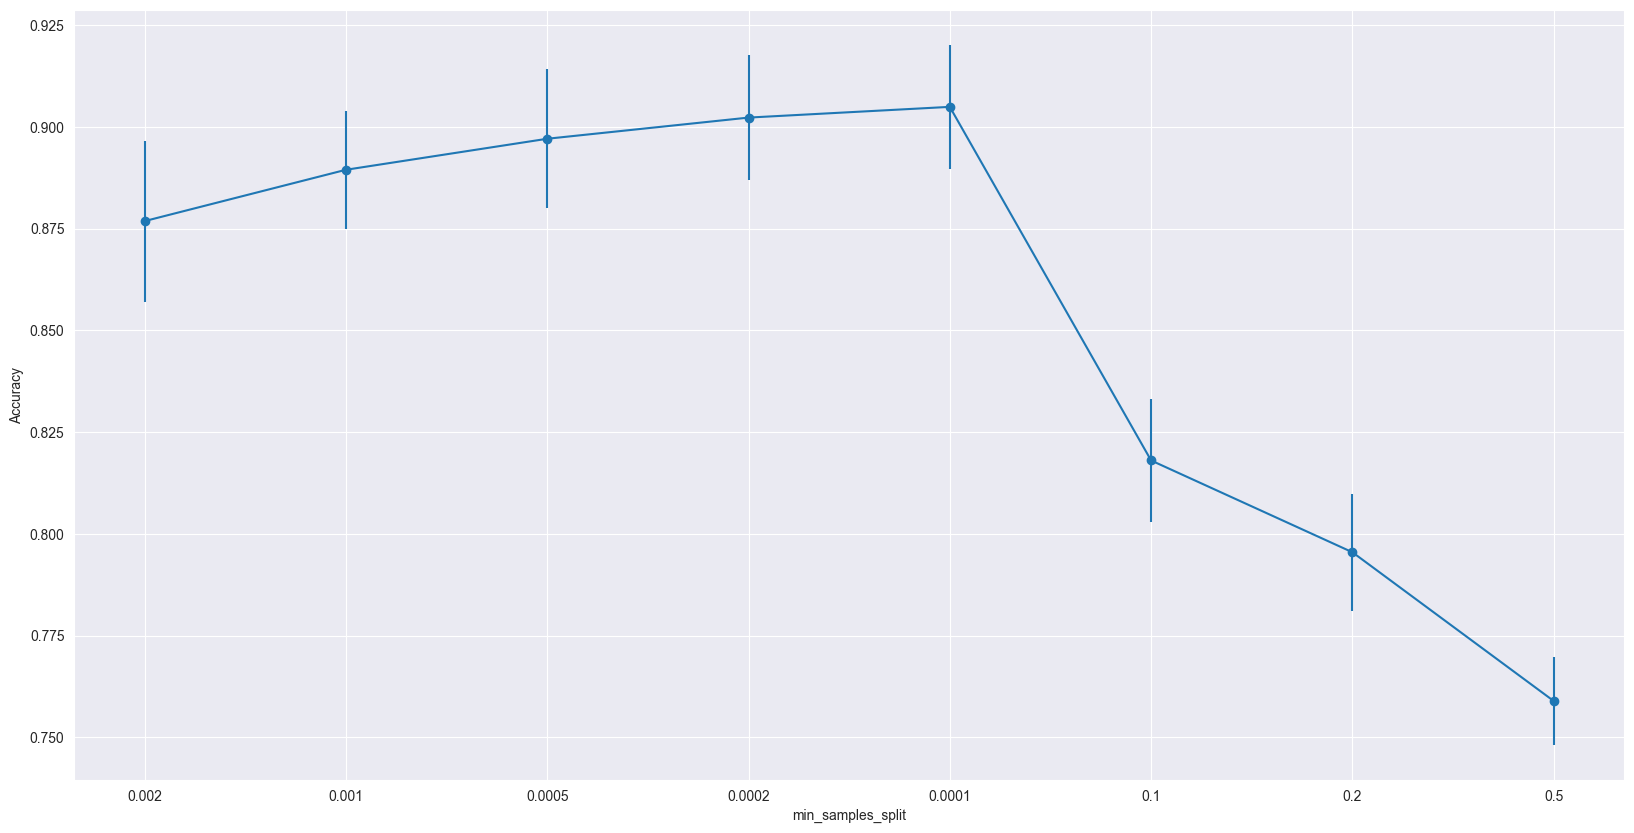

In [116]:
min_samples_splits = [0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.1, 0.2, 0.5]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=42)
    scores = cross_val_score(dt, X_train_smote, y_train_smote, cv=10)
    avg_scores.append(scores.mean())
    std_scores.append(scores.std())
    
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.show()

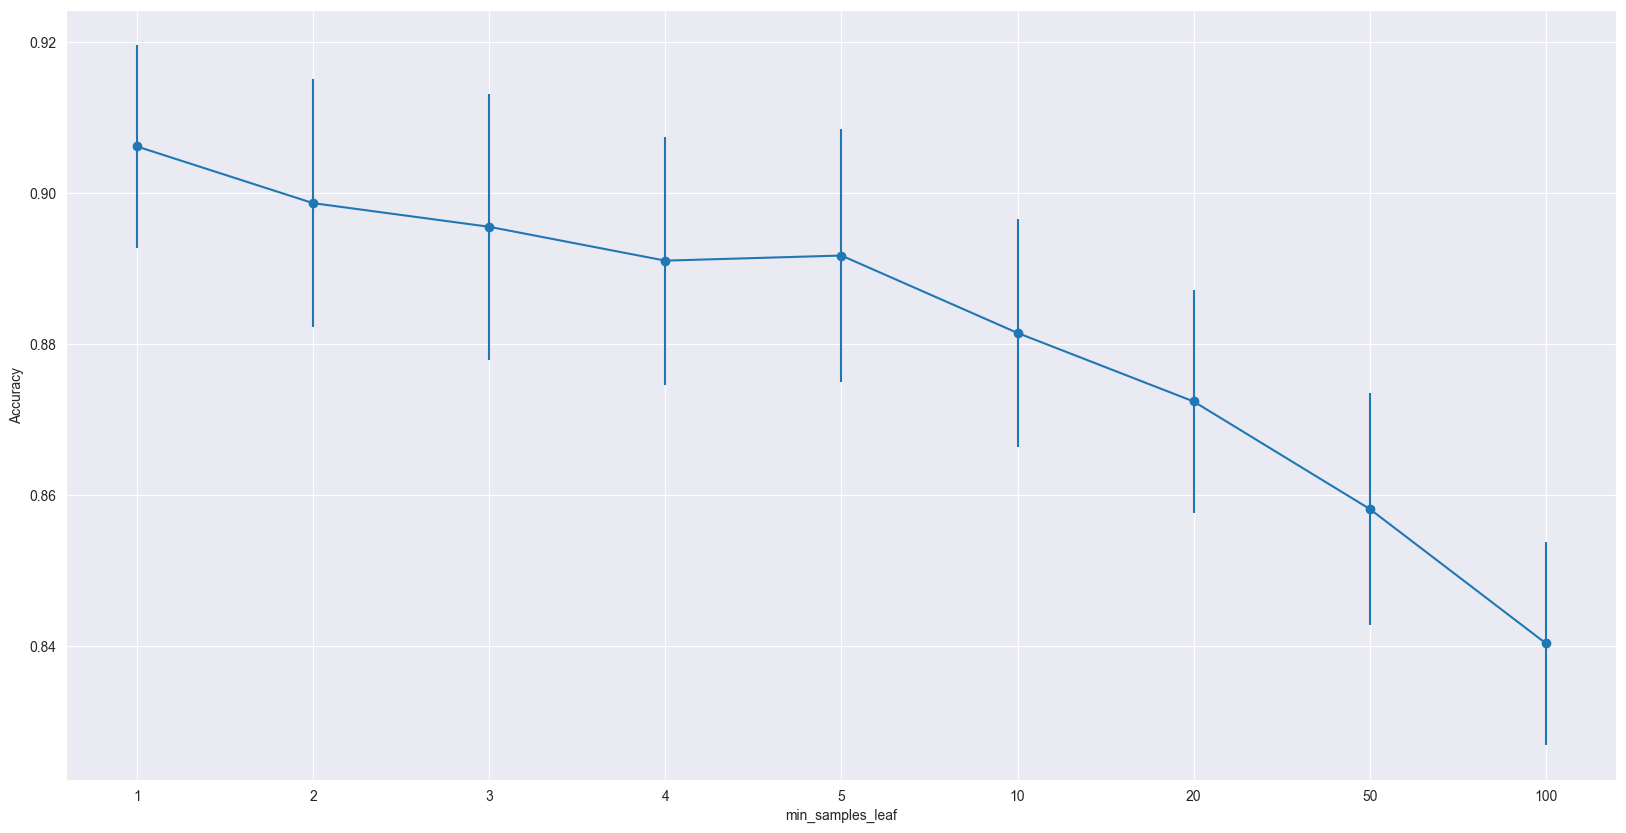

In [115]:
min_samples_leafs = [1, 2, 3, 4, 5, 10, 20, 50, 100]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=42)
    scores = cross_val_score(dt, X_train_smote, y_train_smote, cv=10)
    avg_scores.append(scores.mean())
    std_scores.append(scores.std())
    
plt.figure(figsize=(20, 10))
plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.show()

In [117]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold

In [118]:
param_grid = {
    "max_depth" : [None] + list(np.arange(2,50)),
    "min_samples_split" : [0.002, 0.001, 0.0005, 0.0002, 0.0001, 0.00001, 0.1, 0.2, 0.5],
    "min_samples_leaf" : [1, 2, 3, 4, 5, 10, 20, 50, 100],
    "criterion" : ['gini', 'entropy', 'log_loss']
}

random_search = RandomizedSearchCV(
    DecisionTreeClassifier(), 
    param_distributions=param_grid, 
    cv=RepeatedStratifiedKFold(random_state=0), 
    verbose=2, 
    n_jobs=-1, 
    refit=True,
    n_iter=200
)

random_search.fit(X_train_smote, y_train_smote)
clf = random_search.best_estimator_

Fitting 50 folds for each of 200 candidates, totalling 10000 fits
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.2s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.1s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.1s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.3s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.2s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.2s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.3s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_samples_split=0.002; total time=   1.2s
[CV] END criterion=log_loss, max_depth=28, min_samples_leaf=10, min_sa

In [120]:
print(random_search.best_params_, random_search.best_score_)

{'min_samples_split': 0.0001, 'min_samples_leaf': 1, 'max_depth': 36, 'criterion': 'entropy'} 0.907884431092232


In [153]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=36, min_samples_leaf=1, min_samples_split=0.0001, random_state=42, class_weight={0: 0.1, 1: 10})
clf.fit(X_train_smote, y_train_smote)
y_test_pred = clf.predict(dt_test.drop(columns=['explicit']))
print(classification_report(dt_test['explicit'], y_test_pred))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93      4665
        True       0.23      0.44      0.30       335

    accuracy                           0.87      5000
   macro avg       0.60      0.67      0.61      5000
weighted avg       0.91      0.87      0.88      5000


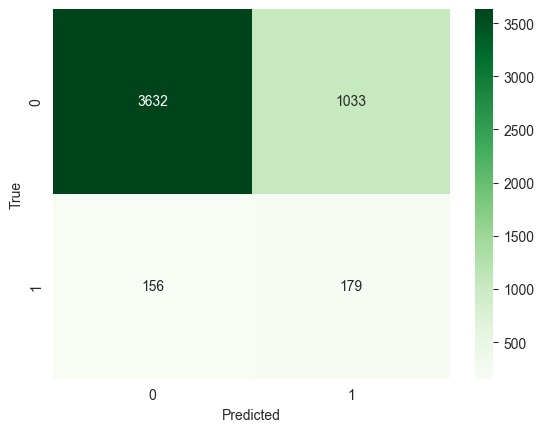

In [137]:
cf = confusion_matrix(dt_test['explicit'], y_test_pred)
sns.heatmap(cf, annot=True, cmap='Greens', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

IndexError: list index out of range

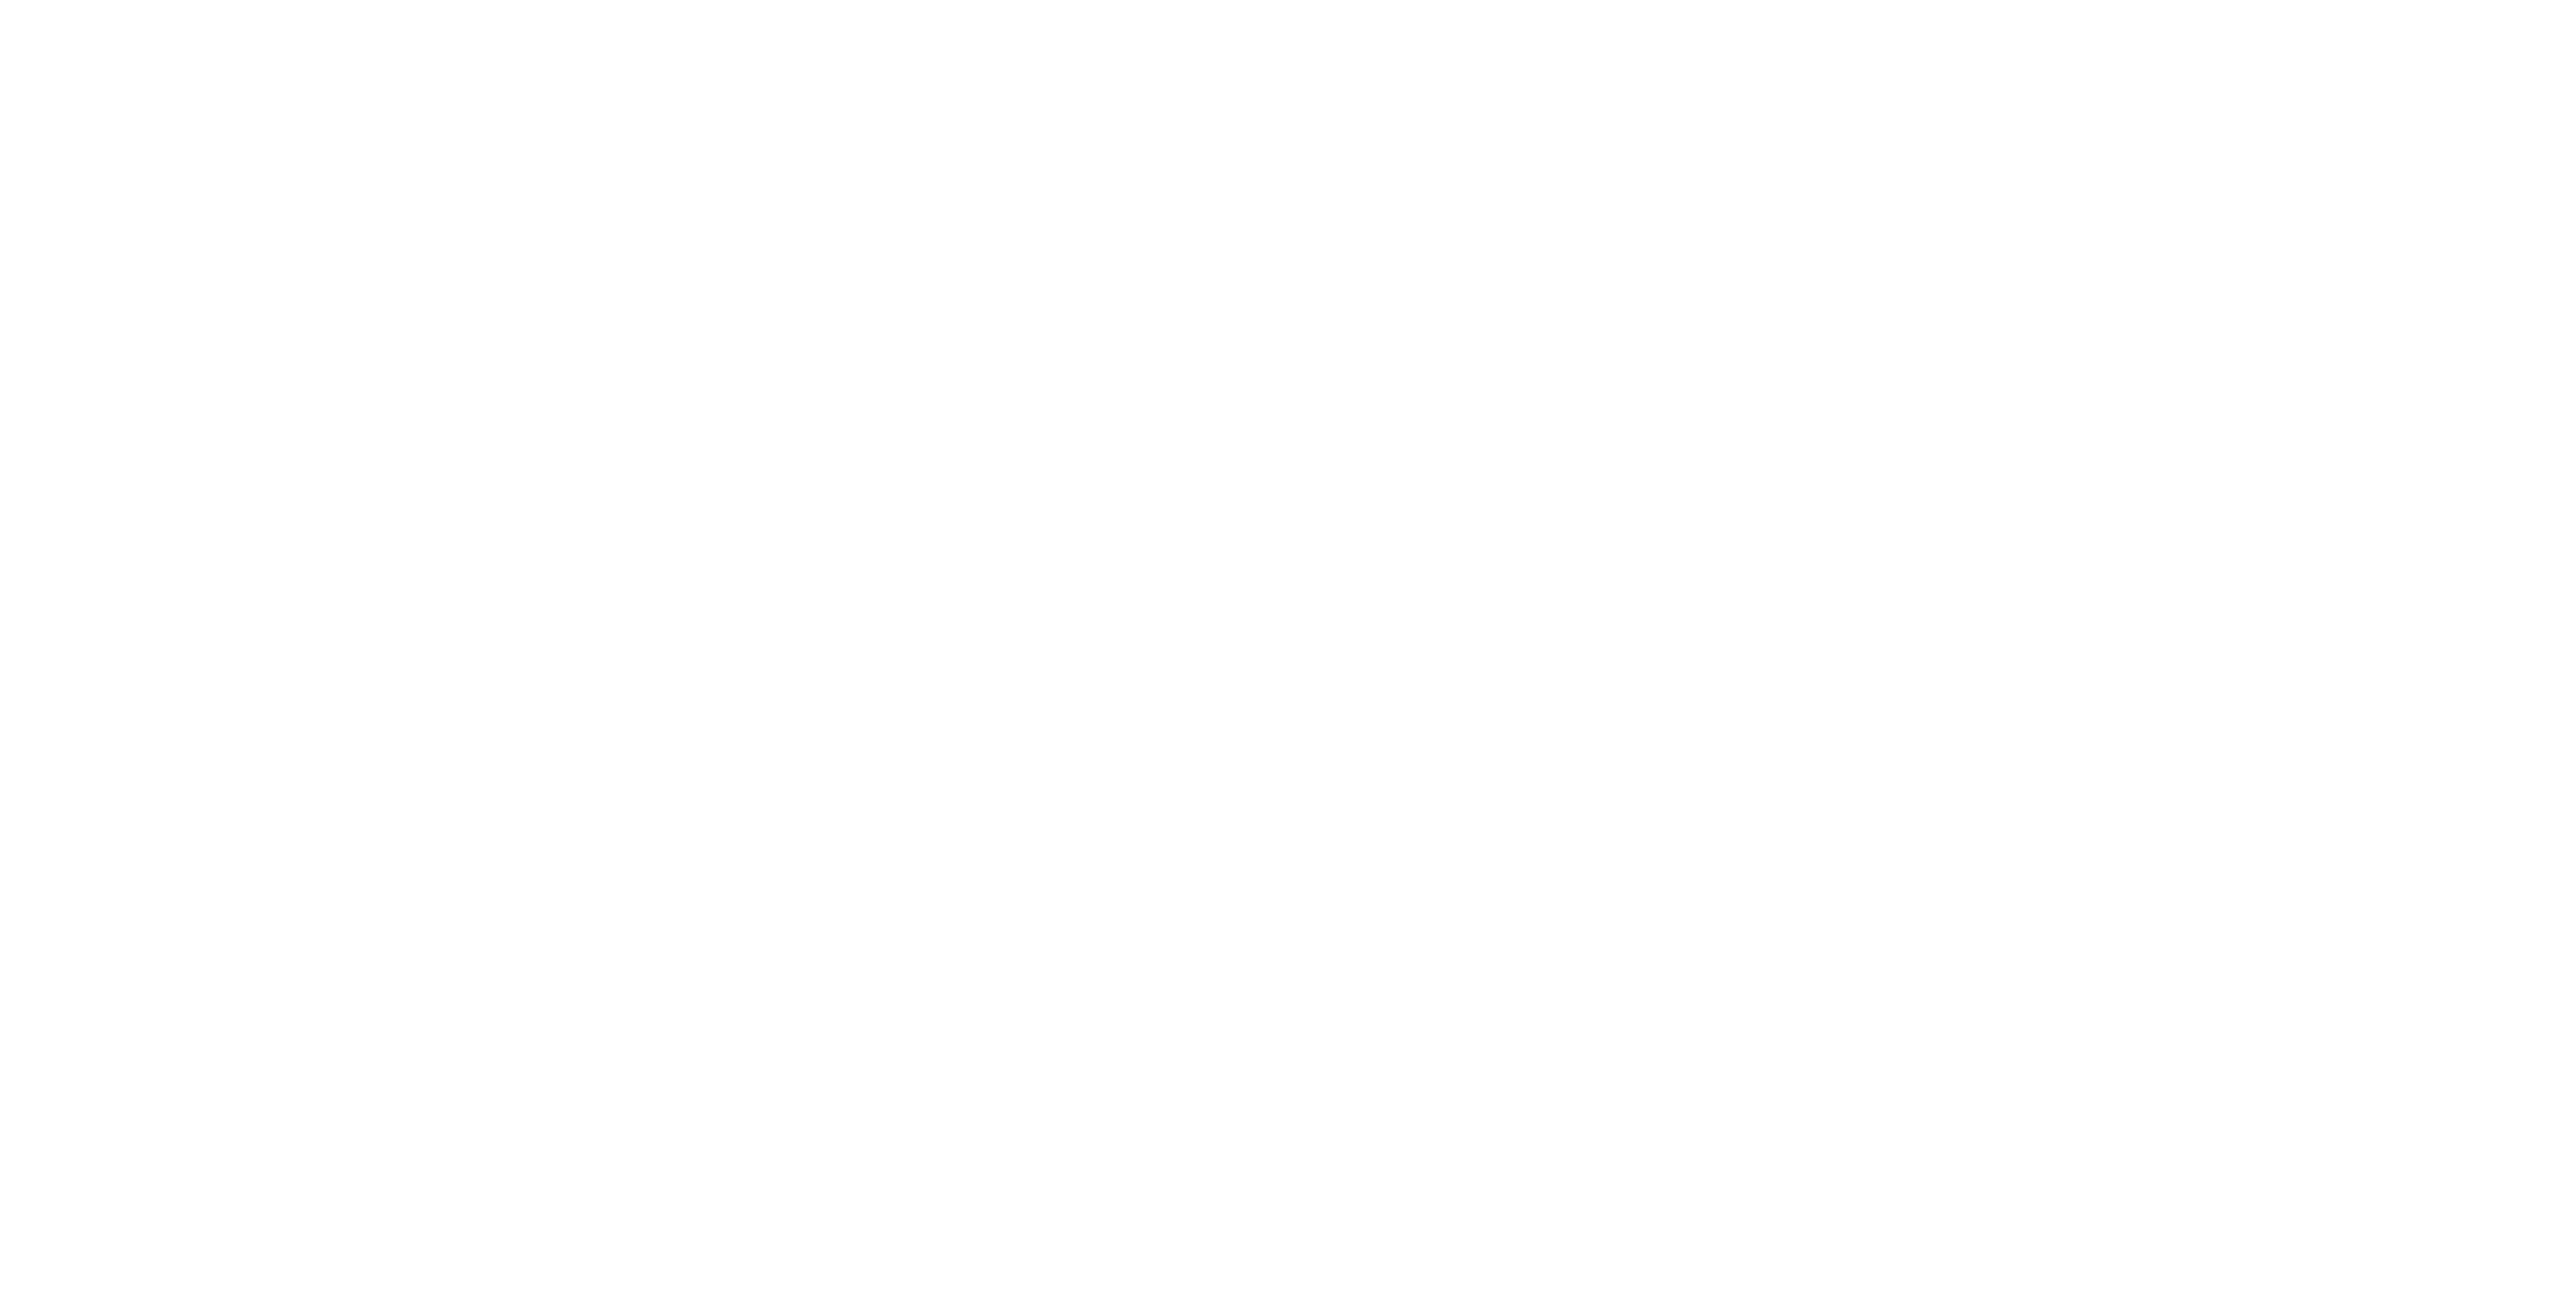

In [138]:
plt.figure(figsize=(20, 10), dpi=300)
plot_tree(clf, filled=True, feature_names=X_train_smote.columns, class_names=['Not_explicit', 'Explicit'])
plt.show()